In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [40]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS, H = 26, 26, 5, 5000, 100
learning_rate = 0.001

class TwoLayerNN(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(TwoLayerNN, self).__init__()
        #self.Linear = torch.nn.Linear(D_in, D_out)
        self.Linear1 = torch.nn.Linear(D_in, H)
        self.Linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h = self.Linear1(x)
        h_relu = F.relu(h, inplace=False)
        y_pred = self.Linear2(h_relu)
        return y_pred
        

In [41]:
model = TwoLayerNN(HEIGHT * WIDTH, NUM_CLASSES)

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [43]:
def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [44]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

In [45]:
import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = train_seqs[i].astype(np.float32)
    y = train_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    lst = list(model.parameters())
    w1 = lst[0].data.numpy()
    b1 = lst[1].data.numpy()
    w2 = lst[2].data.numpy()
    b2 = lst[3].data.numpy()
    
    for i in range(1000):
        h = x[i].dot(w1.transpose()) + b1
        h_relu = np.maximum(0.0, h)
        y_pred = h_relu.dot(w2.transpose()) + b2
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    y_hat = np.empty(1000)

    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = val_seqs[i].astype(np.float32)
    y = cv_labels[i].astype(np.int)
    
    
    lst = list(model.parameters())
    w1 = lst[0].data.numpy()
    b1 = lst[1].data.numpy()
    w2 = lst[2].data.numpy()
    b2 = lst[3].data.numpy()
    
    for i in range(1000):
        h = x[i].dot(w1.transpose()) + b1
        h_relu = np.maximum(0.0, h)
        y_pred = h_relu.dot(w2.transpose()) + b2
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc


In [46]:
train_accs, val_accs = [], []
batch_size = 1
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20  0.23
   100  0.60  0.62
   200  0.64  0.61
   300  0.66  0.66
   400  0.71  0.73
   500  0.68  0.71
   600  0.70  0.71
   700  0.74  0.73
   800  0.71  0.72
   900  0.70  0.71
  1000  0.71  0.71
  1100  0.65  0.71
  1200  0.70  0.70
  1300  0.74  0.72
  1400  0.73  0.71
  1500  0.74  0.74
  1600  0.73  0.75
  1700  0.72  0.71
  1800  0.73  0.73
  1900  0.71  0.73
  2000  0.72  0.73
  2100  0.76  0.74
  2200  0.77  0.75
  2300  0.75  0.72
  2400  0.75  0.76
  2500  0.73  0.74
  2600  0.77  0.75
  2700  0.76  0.77
  2800  0.75  0.70
  2900  0.79  0.78
  3000  0.75  0.76
  3100  0.75  0.77
  3200  0.79  0.78
  3300  0.75  0.74
  3400  0.75  0.75
  3500  0.75  0.76
  3600  0.74  0.75
  3700  0.78  0.78
  3800  0.77  0.80
  3900  0.79  0.77
  4000  0.74  0.77
  4100  0.76  0.78
  4200  0.79  0.79
  4300  0.74  0.74
  4400  0.78  0.76
  4500  0.76  0.74
  4600  0.78  0.77
  4700  0.77  0.76
  4800  0.78  0.78
  4900  0.76  0.78


max_train accuracy:  0.788
max_val accuracy:  0.802


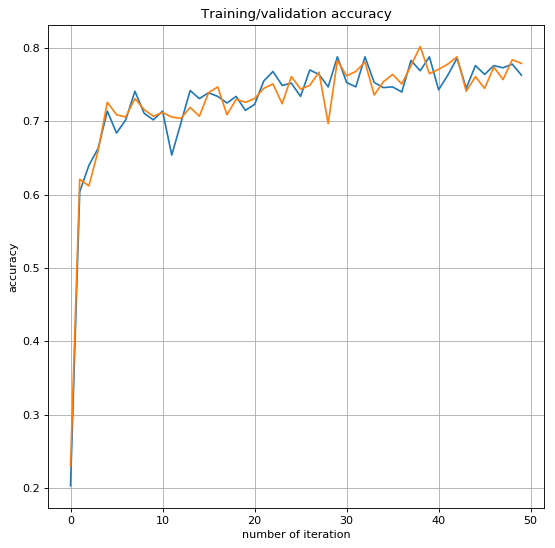

In [47]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

In [49]:
for m in model.children():
    m.reset_parameters()

In [50]:
train_accs, val_accs = [], []
batch_size = 10
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.18  0.20
   100  0.73  0.74
   200  0.74  0.74
   300  0.77  0.77
   400  0.78  0.78
   500  0.77  0.77
   600  0.78  0.80
   700  0.80  0.79
   800  0.81  0.80
   900  0.81  0.82
  1000  0.79  0.80
  1100  0.81  0.79
  1200  0.82  0.81
  1300  0.80  0.82
  1400  0.83  0.82
  1500  0.81  0.81
  1600  0.82  0.80
  1700  0.82  0.80
  1800  0.83  0.83
  1900  0.82  0.83
  2000  0.83  0.83
  2100  0.86  0.84
  2200  0.85  0.82
  2300  0.81  0.84
  2400  0.85  0.83
  2500  0.82  0.83
  2600  0.83  0.82
  2700  0.83  0.82
  2800  0.86  0.83
  2900  0.84  0.82
  3000  0.87  0.83
  3100  0.84  0.84
  3200  0.85  0.83
  3300  0.85  0.83
  3400  0.86  0.80
  3500  0.86  0.83
  3600  0.86  0.83
  3700  0.84  0.84
  3800  0.86  0.83
  3900  0.85  0.84
  4000  0.85  0.81
  4100  0.86  0.86
  4200  0.87  0.84
  4300  0.87  0.82
  4400  0.88  0.83
  4500  0.86  0.82
  4600  0.87  0.84
  4700  0.88  0.83
  4800  0.87  0.82
  4900  0.87  0.83


max_train accuracy:  0.875
max_val accuracy:  0.856


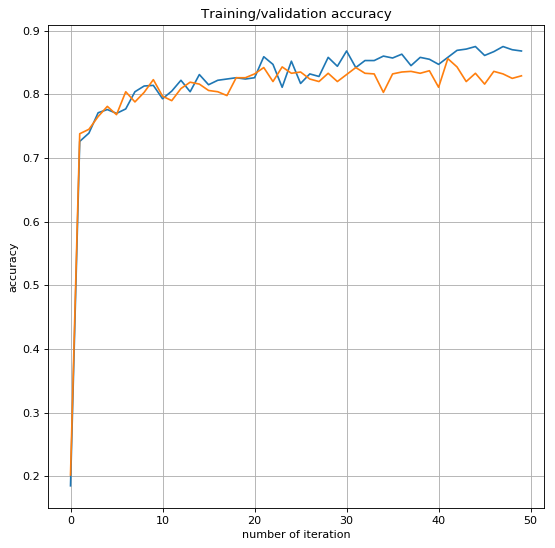

In [51]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()